# **Inteligencja obliczeniowa w analizie danych cyfrowych**

## **Projekt 3: Podstawy Gymnasium**

Autorzy: Karolina Surówka, Weronika Hilaszek

In [1]:
!pip install gymnasium
!pip install gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 23.2 MB/s eta 0:00:00


## **Mountain Car Continuous**

Mountain Car MDP to deterministyczny proces decyzyjny Markowa (MDP), który składa się z samochodu umieszczonego w sposób stochastyczny na dnie sinusoidalnej doliny, przy czym jedyne możliwe akcje to przyspieszenia, które można zastosować do samochodu w dowolnym kierunku. Celem MDP jest strategiczne przyspieszenie samochodu, aby osiągnąć stan docelowy na szczycie prawego wzgórza.

**Nagroda**

W każdym kroku czasowym otrzymywana jest negatywna nagroda w wysokości -0.1 * action2, aby karać za podejmowanie działań o dużej wielkości. Jeśli samochód górski osiągnie cel, do negatywnej nagrody za ten krok czasowy dodawana jest dodatnia nagroda w wysokości +100.

**Przestrzenie obserwacji i akcji**

Przestrzeń obserwacji to ndarray o kształcie (2,) z elementami: pozycja samochodu oraz prędkość, a przestrzeń akcji to ndarray o kształcie (1,), reprezentująca siłę kierunkową przyłożoną do samochodu. Akcja jest ograniczona w zakresie [-1,1] i pomnożona przez moc 0.0015.

**Stan początkowy**

Pozycja samochodu jest przypisywana losowo z równomiernego rozkładu w przedziale [-0.6, -0.4]. Początkowa prędkość samochodu zawsze jest ustawiana na 0.

**Koniec epizodu**

Epizod kończy się, jeśli nastąpi jedno z poniższych zdarzeń:

Termination: Pozycja samochodu jest większa lub równa 0.45 (pozycja docelowa na szczycie prawego wzgórza).

Truncation: Długość epizodu osiąga 999.

In [2]:
from __future__ import annotations
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import gymnasium as gym

In [3]:
# if torch.cuda.is_available():
#     gpu_name = torch.cuda.get_device_name(torch.cuda.current_device())
#     total_memory = torch.cuda.get_device_properties(0).total_memory
#     total_memory_gb = total_memory / (1024**3) # Converting memory to Gb
#     print("GPU is available. \nUsing GPU")
#     print("\nGPU Name:", gpu_name)
#     print(f"Total GPU Memory: {total_memory_gb:.2f} GB")

#     device = torch.device('cuda')
# else:
#     print("GPU is not available. \nUsing CPU")
#     device = torch.device('cpu')

### **Inicjalizacja środowiska Gymnasium:**

In [4]:
env = gym.make('MountainCarContinuous-v0')

### **Klasa `Policy_Network` definiuje parametryzowaną sieć neuronową reprezentującą politykę w przestrzeni ciągłej akcji. Sieć ta przewiduje średnią i odchylenie standardowe rozkładu normalnego, z którego próbkowane są akcje.**

In [5]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        super().__init__()

        hidden_space1 = 16  # Nothing special with 16, feel free to change
        hidden_space2 = 32  # Nothing special with 32, feel free to change

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

## **Implementacja algorytmu REINFORCE z różnymi wartościami gamma (0.9, 0.7 i 0.5):**

In [6]:
class REINFORCE_09:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 0.0001  # Learning rate for policy optimization
        self.gamma = 0.9  # Discount factor
        self.eps = 0.000001  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

In [7]:
class REINFORCE_07:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 0.0001  # Learning rate for policy optimization
        self.gamma = 0.7  # Discount factor
        self.eps = 0.000001  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

In [8]:
class REINFORCE_05:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 0.0001  # Learning rate for policy optimization
        self.gamma = 0.5  # Discount factor
        self.eps = 0.000001  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

### **Środowisko jest opakowane przez wrapper RecordEpisodeStatistics, który rejestruje statystyki, takie jak nagrody za epizod, aby móc je analizować po zakończeniu symulacji. Symulacja jest przeprowadzana z użyciem ziarna losowości (tutaj = 3).**

In [11]:
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(1000)  # Total number of episodes
obs_space_dims = env.observation_space.shape[0]
action_space_dims = env.action_space.shape[0]
rewards_over_seeds_1 = []
rewards_over_seeds_2 = []
rewards_over_seeds_3 = []

for seed in [3]:
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent_1 = REINFORCE_09(obs_space_dims, action_space_dims)
    reward_over_episodes_1 = []

    agent_2 = REINFORCE_07(obs_space_dims, action_space_dims)
    reward_over_episodes_2 = []

    agent_3 = REINFORCE_05(obs_space_dims, action_space_dims)
    reward_over_episodes_3 = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent_1.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent_1.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes_1.append(wrapped_env.return_queue[-1])
        agent_1.update()

        if episode % 50 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds_1.append(reward_over_episodes_1)

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent_2.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent_2.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes_2.append(wrapped_env.return_queue[-1])
        agent_2.update()

        if episode % 50 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds_2.append(reward_over_episodes_2)

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent_3.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent_3.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes_3.append(wrapped_env.return_queue[-1])
        agent_3.update()

        if episode % 50 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds_3.append(reward_over_episodes_3)

Episode: 0 Average Reward: -74
Episode: 50 Average Reward: -67
Episode: 100 Average Reward: -59
Episode: 150 Average Reward: -49
Episode: 200 Average Reward: -45
Episode: 250 Average Reward: -39
Episode: 300 Average Reward: -34
Episode: 350 Average Reward: -30
Episode: 400 Average Reward: -26
Episode: 450 Average Reward: -23
Episode: 500 Average Reward: -20
Episode: 550 Average Reward: -17
Episode: 600 Average Reward: -15
Episode: 650 Average Reward: -13
Episode: 700 Average Reward: -11
Episode: 750 Average Reward: -10
Episode: 800 Average Reward: -9
Episode: 850 Average Reward: -8
Episode: 900 Average Reward: -7
Episode: 950 Average Reward: -6
Episode: 0 Average Reward: -6
Episode: 50 Average Reward: -42
Episode: 100 Average Reward: -34
Episode: 150 Average Reward: -28
Episode: 200 Average Reward: -23
Episode: 250 Average Reward: -19
Episode: 300 Average Reward: -16
Episode: 350 Average Reward: -13
Episode: 400 Average Reward: -11
Episode: 450 Average Reward: -9
Episode: 500 Average R

## **Wizualizacja wyników dla wszystkich eksperymentów:**

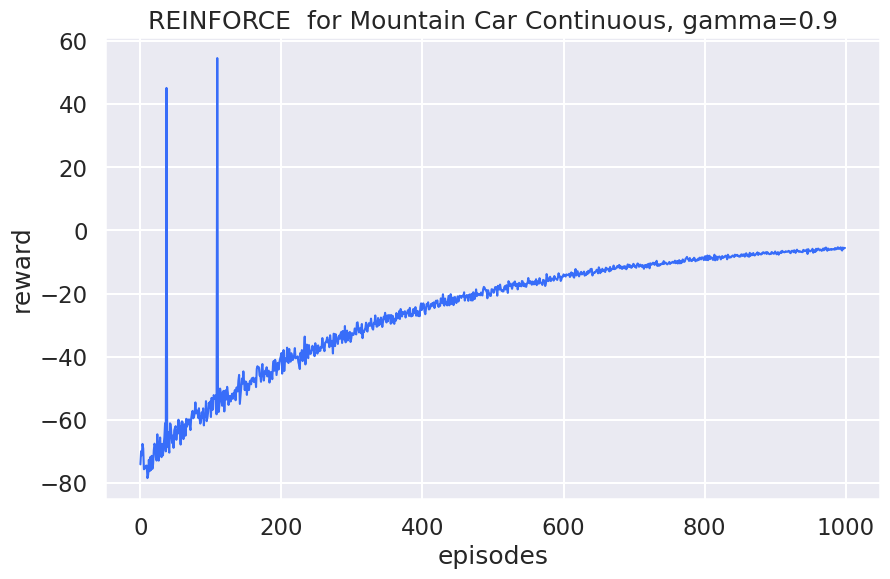

In [21]:
plt.figure(figsize=(10, 6))
rewards_to_plot_1 = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds_1]
df1 = pd.DataFrame(rewards_to_plot_1).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="REINFORCE  for Mountain Car Continuous, gamma=0.9"
)
plt.show()

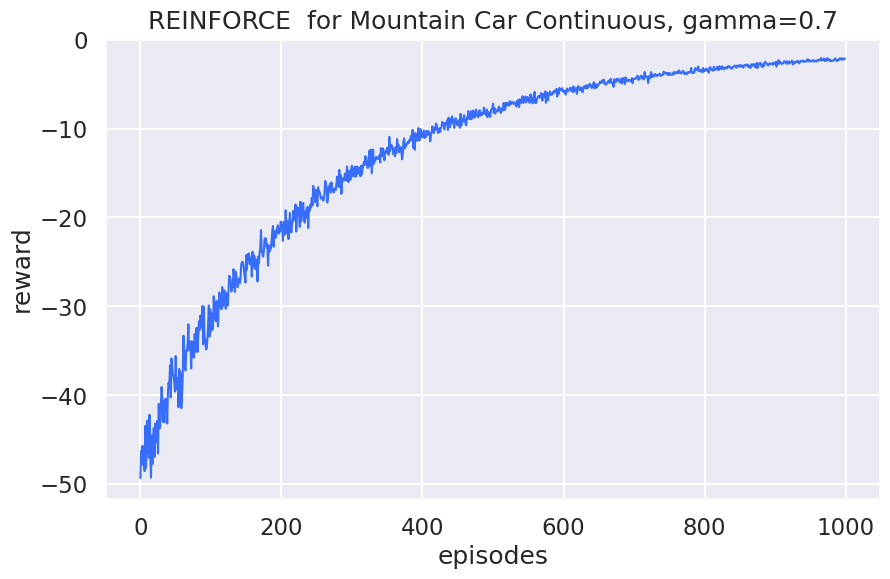

In [22]:
plt.figure(figsize=(10, 6))
rewards_to_plot_2 = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds_2]
df2 = pd.DataFrame(rewards_to_plot_2).melt()
df2.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df2, linewidth=1.5).set(
    title="REINFORCE  for Mountain Car Continuous, gamma=0.7"
)
plt.show()

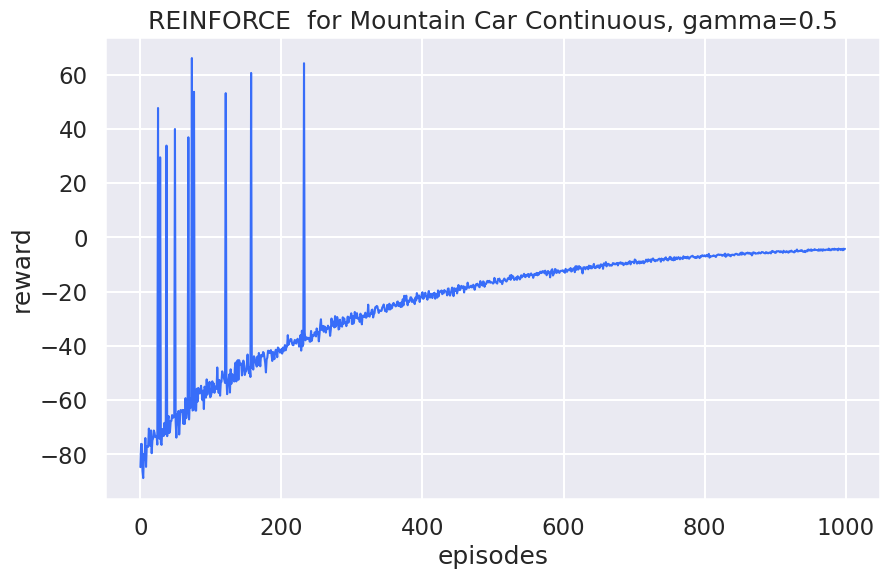

In [23]:
plt.figure(figsize=(10, 6))
rewards_to_plot_3 = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds_3]
df3 = pd.DataFrame(rewards_to_plot_3).melt()
df3.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df3, linewidth=1.5).set(
    title="REINFORCE  for Mountain Car Continuous, gamma=0.5"
)
plt.show()

## **Wnioski**

Zaprezentowano eksperymenty dla trzech różnych wartości współczyników dyskontowania: kolejno 0.9, 0.7 i 0.5. Wybór współczynnika dyskontowania gamma ma znaczący wpływ na szybkość i kształt uczenia się agenta w zadaniu Mountain Car Continuous. Najstabilniejszy przebieg uczenia został uzyskany dla współczynnika = 0.7, gdzie nie występują aż tak duże zawahania jak dla 0.5. Dla gammy = 0.5 na początku występują fluktuacje, ale z upływem epizodów widoczna jest poprawa. Dla najwyższej gammy = 0.9 agent początkowo ponownie doświadcza dużych zawahań, ale z czasem się poprawia - wyższa gamma może być przydatna w perspektywie długoterminowej.